<a href="https://colab.research.google.com/github/openknowledge/mlops-data2day/blob/main/notebooks/exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Much more extensive version of train notebook, but unfortunately outdated and broken in some parts


In [1]:
# If this gives red output everything is fine
import tensorflow as tf
tf.__version__

2023-04-28 15:20:35.787291: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-28 15:20:35.789850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 15:20:35.839173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-28 15:20:35.839997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 15:20:36.901068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

'2.12.0'

In [2]:
# disable gpus, can also give red output and everything is just fine
tf.config.set_visible_devices([], 'GPU')

In [3]:
tf.random.set_seed(42)

In [4]:
import numpy as np
np.__version__

'1.23.5'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 16

In [6]:
# https://github.com/AndreasMadsen/python-lrcurve
# uncomment for Colab
!pip install -q lrcurve

In [7]:
from lrcurve import KerasLearningCurve

# Step 1: Loading and exploring our data set

In [8]:
import pandas as pd

# uncomment for Colab
# df = pd.read_csv('https://raw.githubusercontent.com/openknowledge/mlops/main/data/reference.csv', delimiter=';')
df = pd.read_csv(f'../../datasets/insurance_prediction/reference.csv', delimiter=';')

In [9]:
df.head(10)

,training,age,emergency_braking,braking_distance,power,miles,risk,group_name,group
0,0,41.951100,0,40.933328,122.238329,98.509765,3.700073,high,0
1,0,24.368286,1,44.797317,113.765298,46.324178,2.447873,medium,1
2,0,18.314649,1,41.587241,143.427269,76.862968,4.079834,high,0
3,0,51.265254,1,47.266716,111.578133,102.697069,5.087831,high,0
4,0,23.578861,0,42.835319,145.994235,63.690055,3.739299,high,0
5,0,29.506037,1,46.547745,139.820214,66.610999,3.130142,high,0
6,0,21.289385,1,40.666499,134.749599,63.146964,1.774027,medium,1
7,1,47.459483,0,35.168550,142.215391,123.385272,0.084924,low,2
8,1,20.573680,1,41.798826,114.677871,103.853842,-0.033755,low,2
9,0,24.639606,1,40.801391,162.457198,44.292386,2.456763,medium,1


In [10]:
df.describe()

,training,age,emergency_braking,braking_distance,power,miles,risk,group
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.210000,35.146663,0.394000,39.903294,134.888089,80.965668,2.183617,0.901333
std,0.407444,12.765348,0.488798,4.781834,35.048570,25.496752,2.481164,0.815705
min,0.000000,15.949545,0.000000,24.368993,38.246253,18.796953,-5.289352,0.000000
25%,0.000000,25.141921,0.000000,36.733165,110.008660,62.666195,0.708085,0.000000
50%,0.000000,32.714683,0.000000,39.867888,131.055019,77.094819,2.386835,1.000000
75%,0.000000,42.633629,1.000000,42.938777,157.319959,95.568682,3.874869,2.000000
max,1.000000,86.213394,1.000000,56.463472,285.750164,211.807417,10.343054,2.000000


In [11]:
import seaborn as sns

In [12]:
labels = ["High Risk", "Medium Risk", "Low Risk"]
markers = ['v', 'd', '^']
# colors = ['#FF8080', '#FFFF80', '#8080FF']
colors = ['#FF0000', '#FFFF00', '#0000FF']

In [13]:
features = ['training', 'age', 'emergency_braking', 'braking_distance', 'power', 'miles', 'risk']

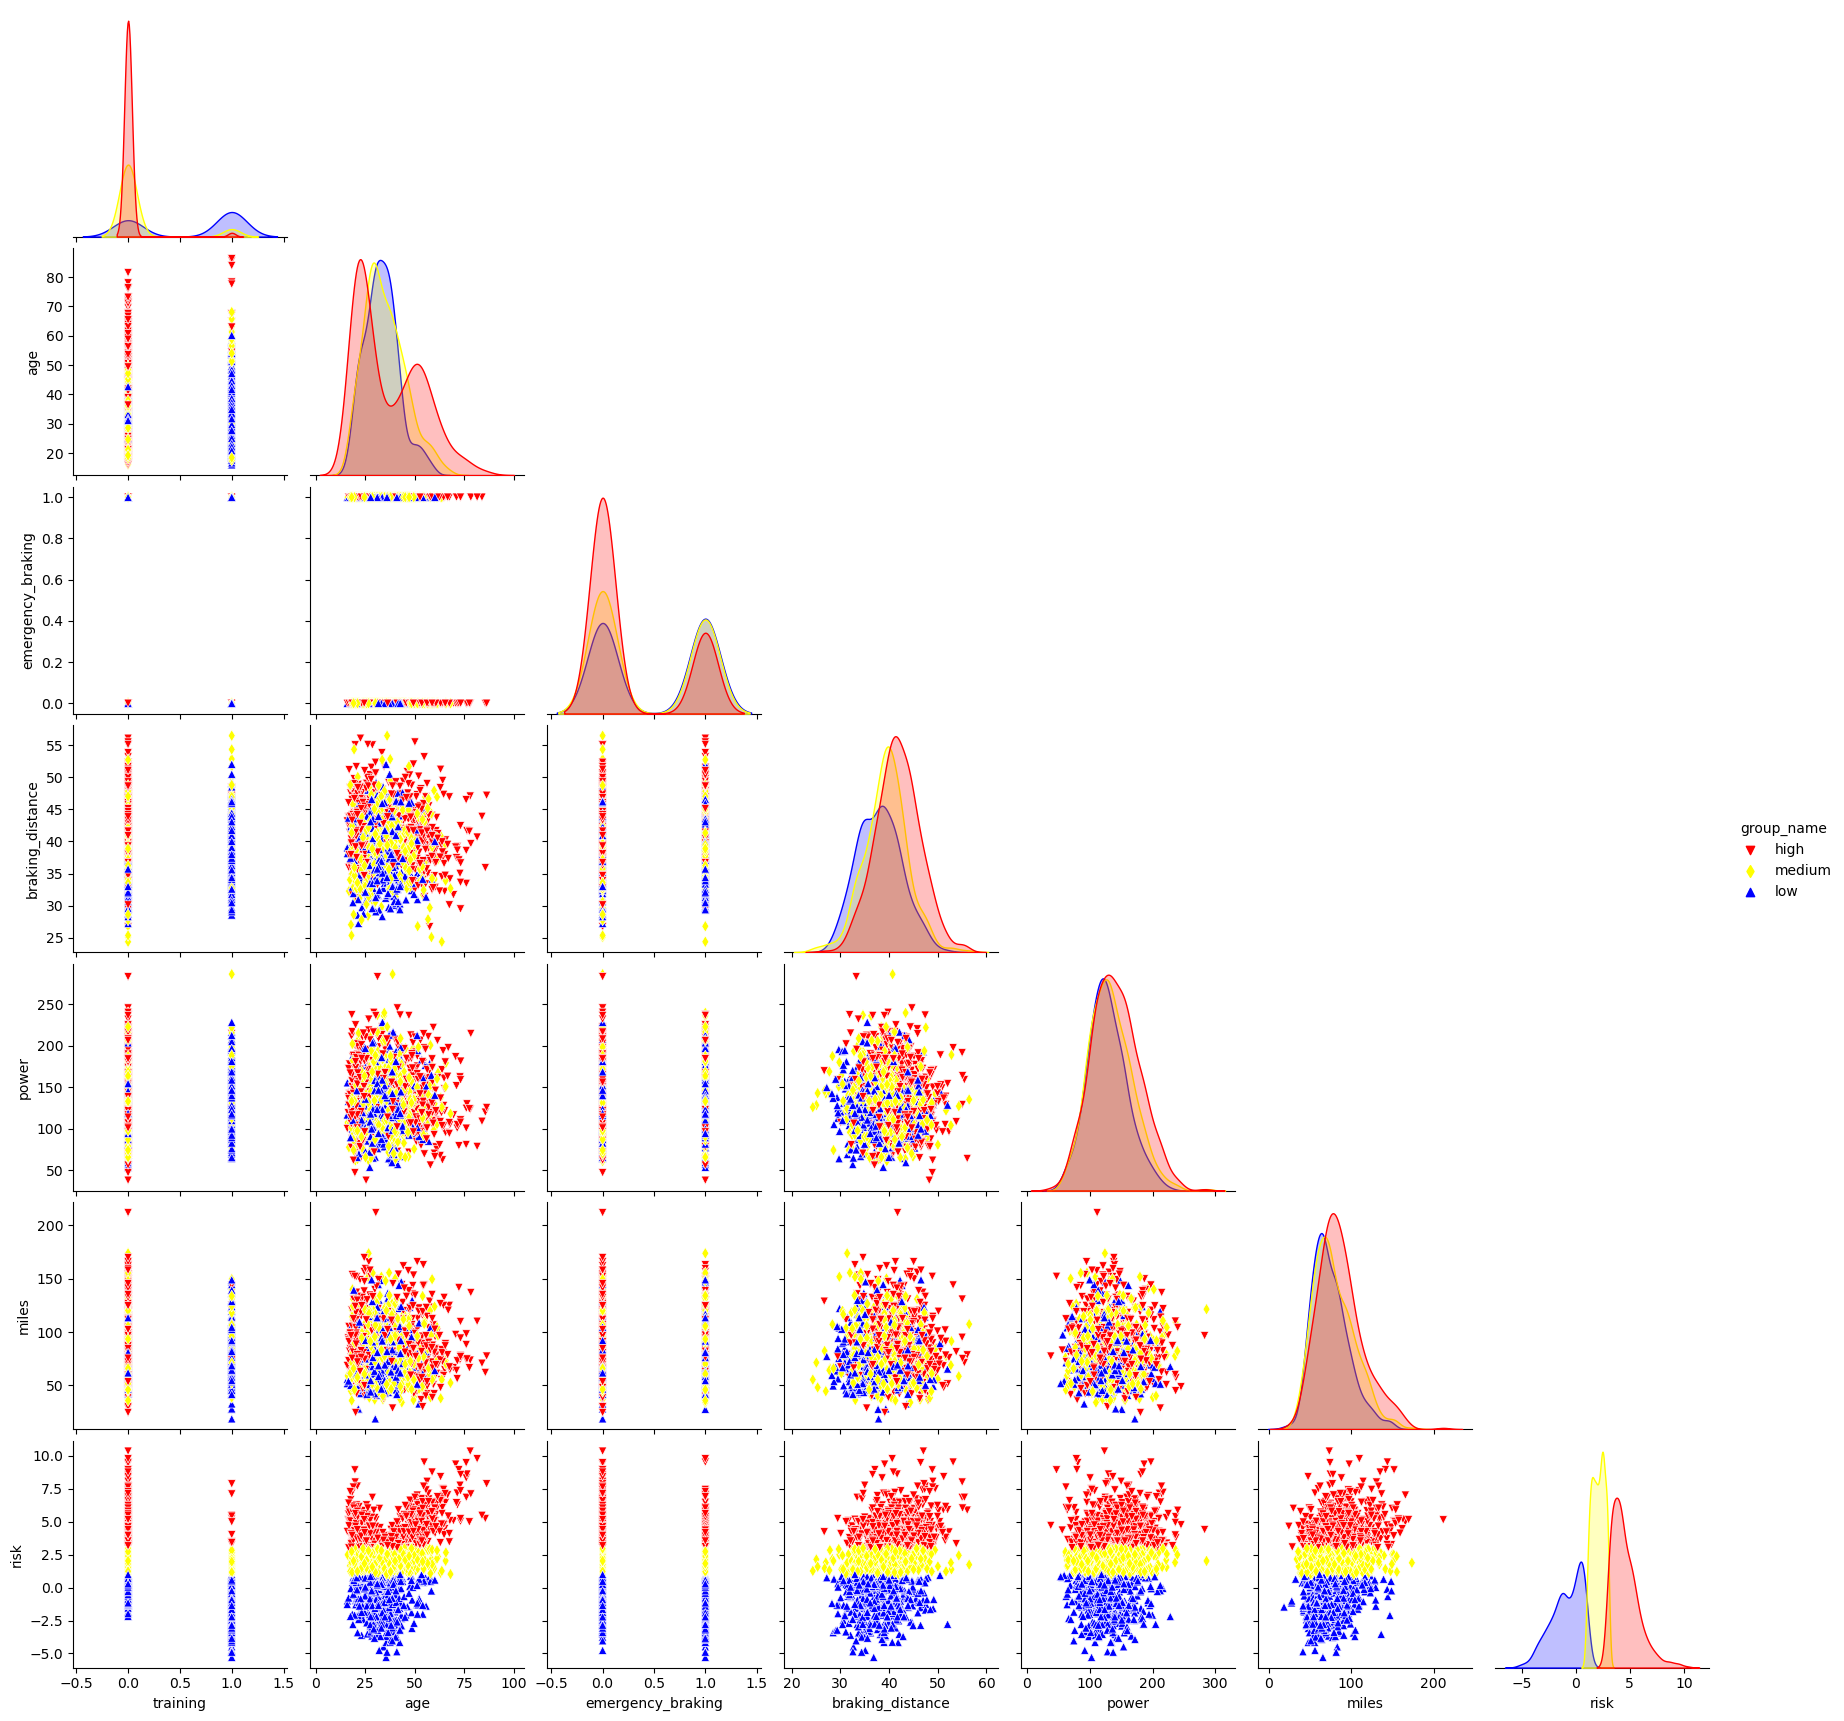

In [14]:
sns.pairplot(df, 
             kind="scatter", 
             diag_kind="kde",
             corner=True, 
             hue='group_name',
             hue_order = ['high', 'medium', 'low'],
             palette=colors, 
             markers=markers,
             vars=features);

# Step 2: Training a neural network

## First extract train and test for automated scripts

In [15]:
y = df['group'].values
np.unique(y, return_counts=True)

(array([0, 1, 2]), array([580, 488, 432]))

In [16]:
from sklearn.model_selection import train_test_split
train_np, val_np, _, _ = train_test_split(df.values, df['group'].values, test_size=0.2, random_state=21, stratify=y)
train_np.shape, val_np.shape

((1200, 9), (300, 9))

In [17]:
df_train = pd.DataFrame(train_np, columns=df.columns)
df_train.to_csv('../../datasets/insurance_prediction/train.csv', index=False, sep=';')

In [18]:
df_test = pd.DataFrame(val_np, columns=df.columns)
df_test.to_csv('../../datasets/insurance_prediction/test.csv', index=False, sep=';')

## Then extract for training in notebook

In [19]:
X = df.drop(['risk', 'group', 'group_name'], axis='columns').values
X.shape, y.shape

((1500, 6), (1500,))

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 6), (300, 6), (1200,), (300,))

## Normalization

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization

In [21]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [22]:
normalizer.adapt(X_train)

In [23]:
X_train.mean(axis=0), X_train.std(axis=0)

(array([  0.21      ,  35.04868507,   0.38416667,  39.85941241,
        135.44608245,  80.75870963]),
 array([ 0.40730824, 12.83783712,  0.48639761,  4.7835018 , 35.33754623,
        25.39554043]))

In [24]:
normalizer.weights

[<tf.Variable 'mean:0' shape=(6,) dtype=float32, numpy=
 array([  0.20999996,  35.048683  ,   0.38416666,  39.85941   ,
        135.44609   ,  80.75871   ], dtype=float32)>,
 <tf.Variable 'variance:0' shape=(6,) dtype=float32, numpy=
 array([1.6590004e-01, 1.6481006e+02, 2.3658259e-01, 2.2881884e+01,
        1.2487423e+03, 6.4493372e+02], dtype=float32)>,
 <tf.Variable 'count:0' shape=() dtype=int64, numpy=1200>]

In [25]:
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [26]:
normalizer.mean, np.sqrt(normalizer.variance)

(<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
 array([[  0.20999996,  35.048683  ,   0.38416666,  39.85941   ,
         135.44609   ,  80.75871   ]], dtype=float32)>,
 array([[ 0.40730828, 12.837837  ,  0.48639756,  4.783501  , 35.337547  ,
         25.395546  ]], dtype=float32))

In [27]:
from tensorflow.keras.layers import InputLayer, Dense, Dropout, \
                                    BatchNormalization, Activation

num_features = X.shape[1]
dropout = 0.7
neurons_per_layer = 100
# neurons_per_layer = 50

model = tf.keras.Sequential()
model.add(InputLayer(name='input', input_shape=(num_features,)))
model.add(normalizer)

model.add(Dense(neurons_per_layer, name='hidden1'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden2'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(neurons_per_layer, name='hidden3'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='output', units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 hidden1 (Dense)             (None, 100)               700       
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 hidden2 (Dense)             (None, 100)               1

In [28]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
%%time 

BATCH_SIZE = 32
# BATCH_SIZE = 64
EPOCHS = 50

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 17.3 s, sys: 3.4 s, total: 20.7 s
Wall time: 14.4 s


In [30]:
train_loss, train_metric = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_metric

38/38 [==============================] - 0s 4ms/step - loss: 0.3703 - accuracy: 0.8742


(0.37030142545700073, 0.8741666674613953)

In [31]:
test_loss, test_metric = model.evaluate(X_val, y_val, batch_size=BATCH_SIZE)
test_loss, test_metric

10/10 [==============================] - 0s 4ms/step - loss: 0.3636 - accuracy: 0.8933


(0.36355963349342346, 0.8933333158493042)

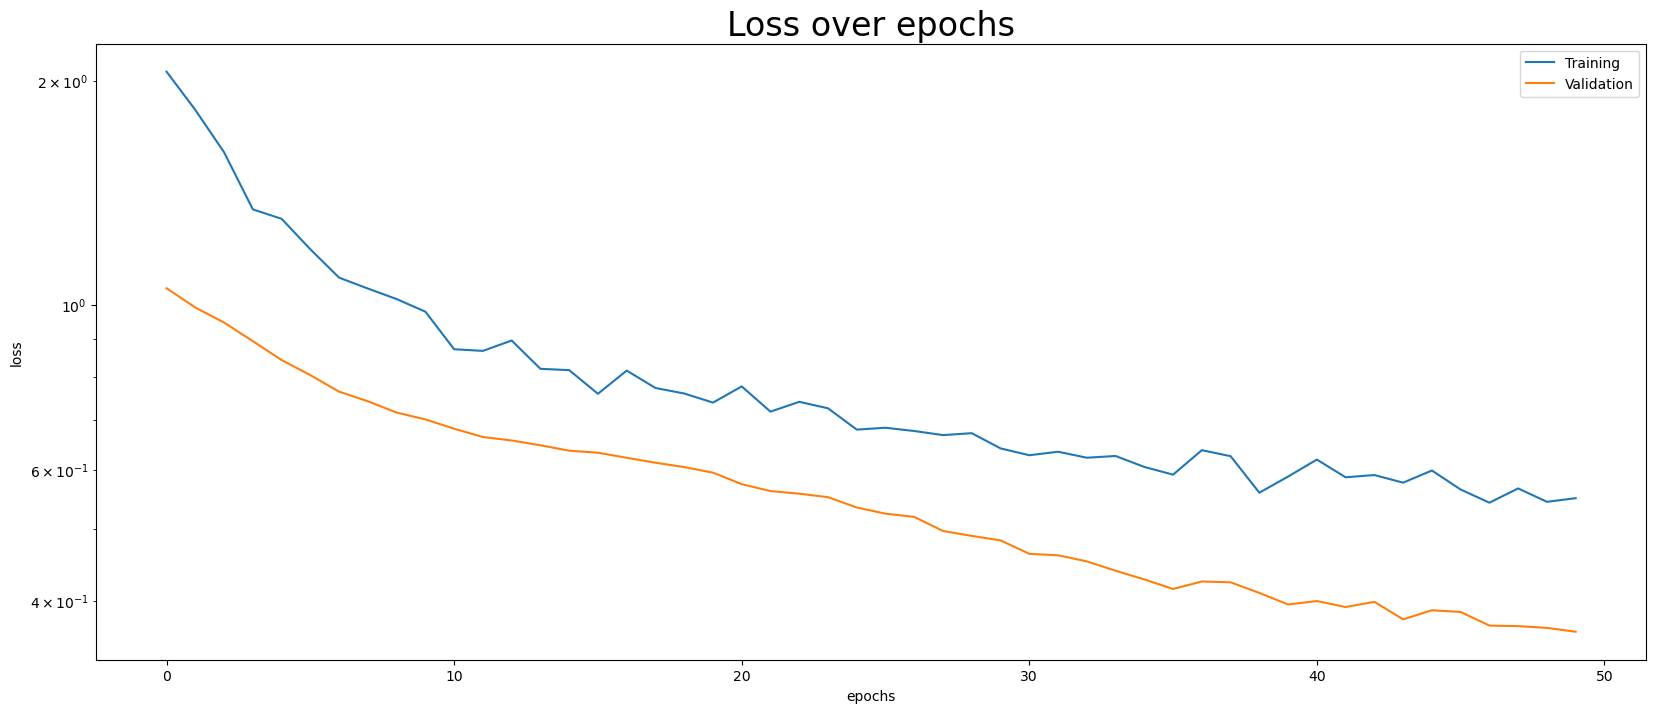

In [32]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over epochs')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

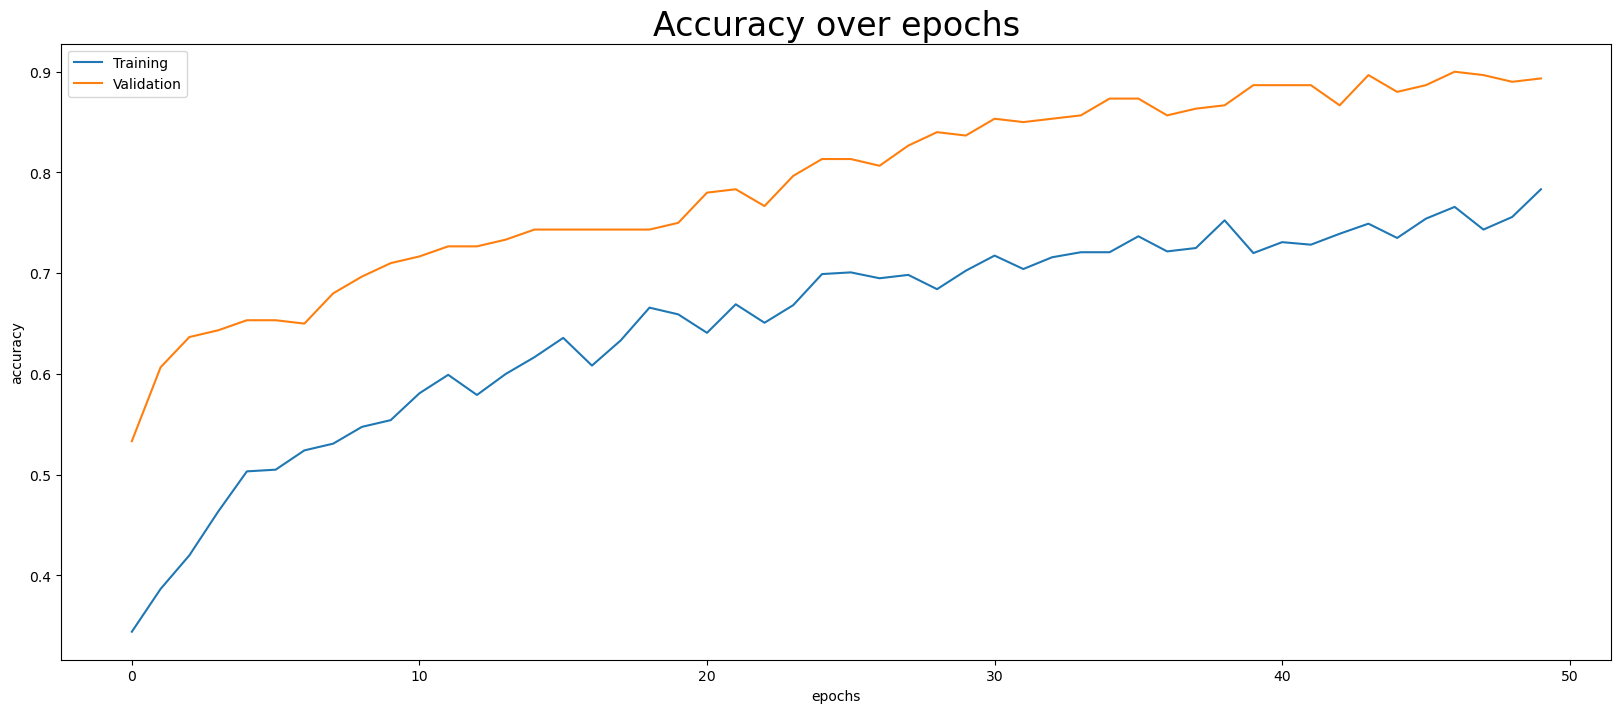

In [33]:
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over epochs')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation']);

# Invariant Properties of Model

## Accuracy range and lack of overfitting

In [34]:
# 85% is sufficient for our use case
assert train_metric > .85

In [35]:
assert test_metric > .85

In [36]:
assert abs(train_metric - test_metric) < .05

In [37]:
# we can not be too good

assert test_metric < .95
assert train_metric < .95

## Invariants of the model itself (without using data on it)
Could be
* effective depth of tree (if decision tree has been used as architecture instead of NN)
* distribution of weights
* actual normalization

**We do use these properties as we want to treat the model as a black box to make it interchangable**

# Invariants also useful for monitoring and analyzis - not using GT

In [38]:
y_pred = model.predict(X).argmax(axis=1)
y_pred.shape

47/47 [==============================] - 0s 4ms/step


(1500,)

## Distribution of Output Class

In [39]:
values, counts = np.unique(y_pred, return_counts=True)
values, counts

(array([0, 1, 2]), array([529, 521, 450]))

In [40]:
# equal distribution around classes expected
tolerance = 0.15
expected_count = len(X) / 3
lower_bound = int(expected_count * (1 - tolerance))
upper_bound = int(expected_count * (1 + tolerance))
print(f'{lower_bound}-{upper_bound}')
                  
for count in counts:
    print(count)
    assert count in range(lower_bound, upper_bound)

425-575
529
521
450


## Distribution of certainty

In [41]:
y_pred_probas = model.predict(X).max(axis=1)
y_pred_probas.shape

47/47 [==============================] - 0s 3ms/step


(1500,)

In [42]:
y_pred_probas.min(), y_pred_probas.mean(), y_pred_probas.max()

(0.47659957, 0.75456315, 0.9998047)

In [43]:
assert y_pred_probas.min() > .4

In [44]:
assert y_pred_probas.mean() > 0.7

In [45]:
assert y_pred_probas.max() > 0.99

## In Monitoring both could be treated as a distribution and compared to the training reference

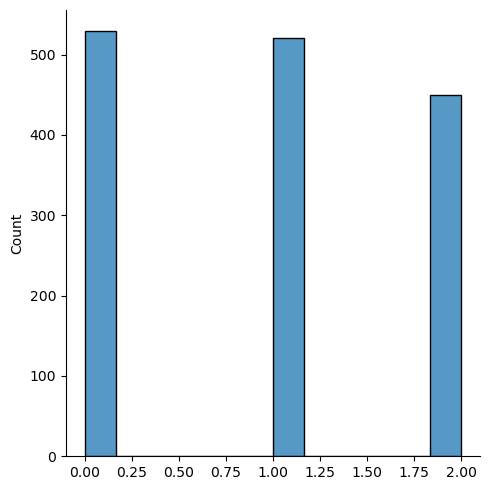

In [46]:
sns.displot(y_pred);

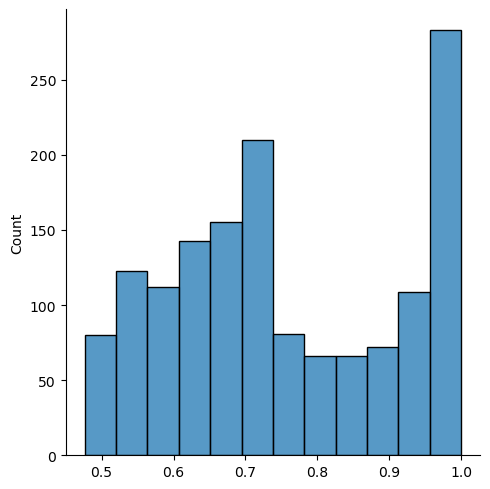

In [47]:
sns.displot(y_pred_probas);

## Since at this point we just have this one dataset, we can try with train vs test

In [48]:
y_train_pred_probas = model.predict(X_train).max(axis=1)
y_test_pred_probas = model.predict(X_val).max(axis=1)

10/10 [==============================] - 0s 4ms/step


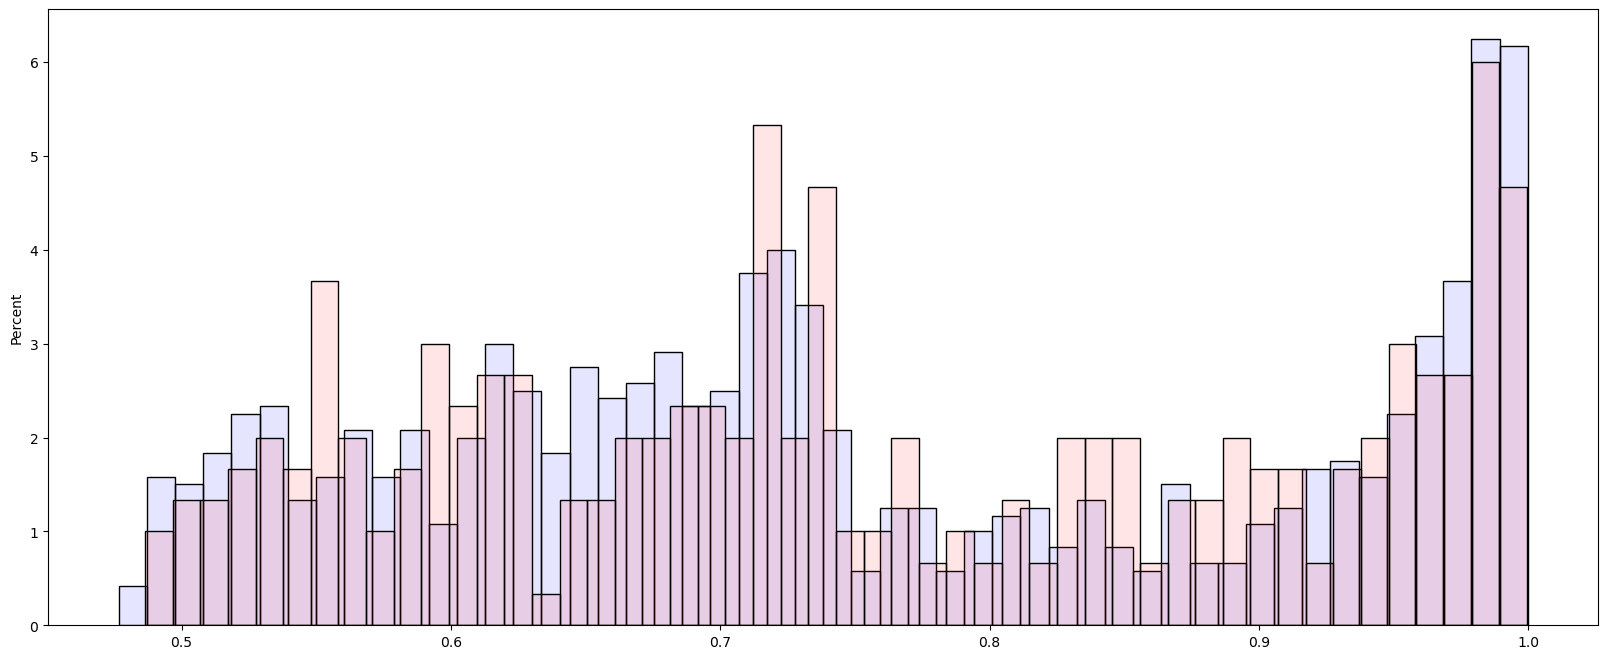

In [49]:
alpha=0.1
sns.histplot(y_train_pred_probas, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_test_pred_probas, color='red', bins=50, stat='percent', alpha=alpha);

In [50]:
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred = model.predict(X_val).argmax(axis=1)

10/10 [==============================] - 0s 3ms/step


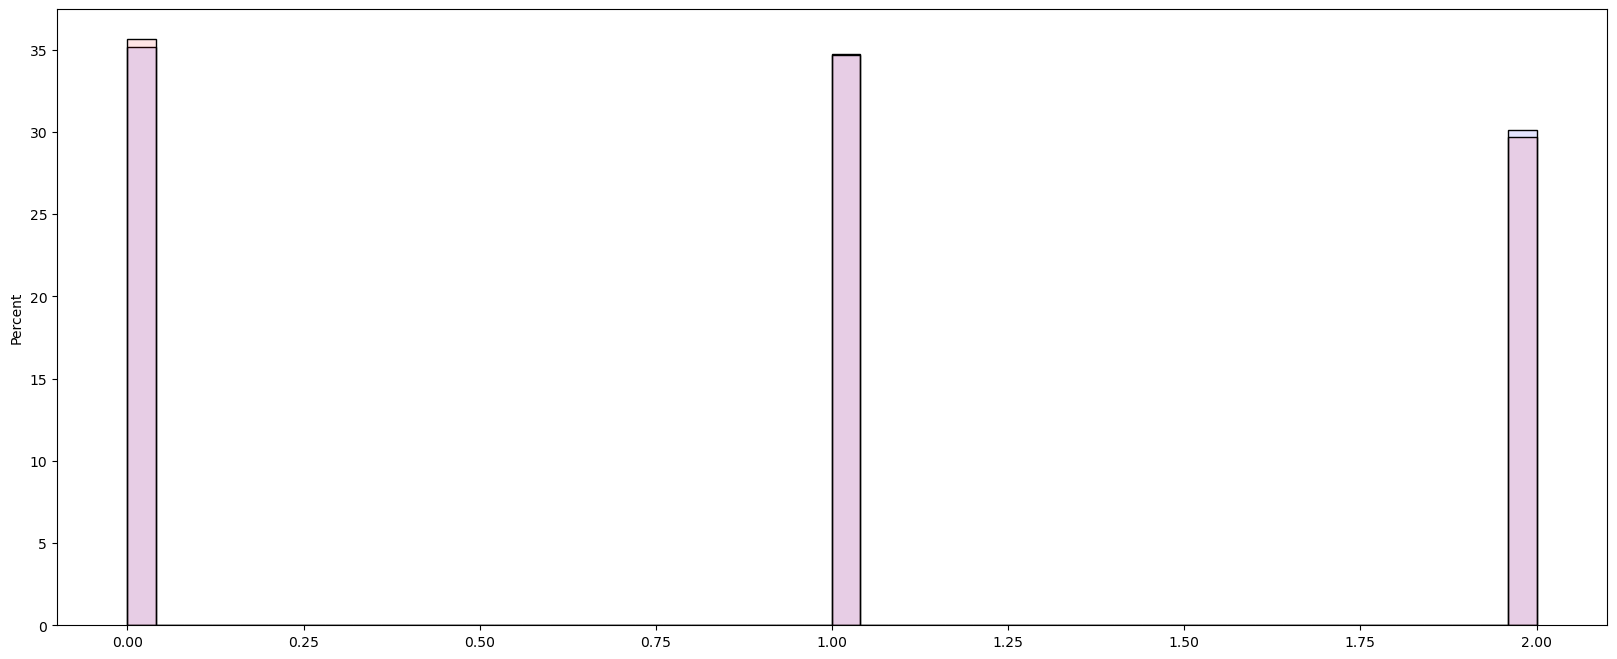

In [51]:
alpha=0.1
sns.histplot(y_train_pred, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_test_pred, color='red', bins=50, stat='percent', alpha=alpha);

## We can have a couple of statistical tests (more valuable in monitoring and real prod data)

In [52]:
# uncomment for Colab
# !pip install -q evidently

In [53]:
import evidently

In [54]:
from evidently.calculations.stattests.jensenshannon import jensenshannon_stat_test
from evidently.calculations.stattests.kl_div import kl_div_stat_test
from evidently.calculations.stattests.ks_stattest import ks_stat_test
from evidently.calculations.stattests.psi import psi_stat_test
from evidently.calculations.stattests.wasserstein_distance_norm import wasserstein_stat_test

In [55]:
wasserstein_stat_test(y_train_pred_probas, y_test_pred_probas, 'num', threshold=None)

StatTestResult(drift_score=0.06379924297846111, drifted=False, actual_threshold=0.1)

In [56]:
ks_stat_test(y_train_pred_probas, y_test_pred_probas, 'num', threshold=None)

StatTestResult(drift_score=0.5544586955981621, drifted=False, actual_threshold=0.05)

In [57]:
psi_stat_test(pd.Series(y_train_pred_probas), pd.Series(y_test_pred_probas), 'num', threshold=None)

StatTestResult(drift_score=0.06622397262796599, drifted=False, actual_threshold=0.1)

In [58]:
jensenshannon_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=0.004042007532250421, drifted=False, actual_threshold=0.1)

In [59]:
psi_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=0.0001307036568470831, drifted=False, actual_threshold=0.1)

In [60]:
kl_div_stat_test(pd.Series(y_train_pred), pd.Series(y_test_pred), 'cat', threshold=None)

StatTestResult(drift_score=6.533672451587268e-05, drifted=False, actual_threshold=0.1)

# Checking against "future" data

Since we are simulating production data we have access to data up 36 months from now

In [61]:
months_from_now = 36
df_prod = pd.read_csv(f'https://raw.githubusercontent.com/openknowledge/mlops-data2day/main/data/month-{months_from_now}.csv', delimiter=';')

In [62]:
X_prod = df_prod.drop(['risk', 'group', 'group_name'], axis='columns').values
X.shape

(1500, 6)

In [63]:
y_prod_pred = model.predict(X_prod).argmax(axis=1)
y_prod_pred_probas = model.predict(X_prod).max(axis=1)

47/47 [==============================] - 0s 3ms/step


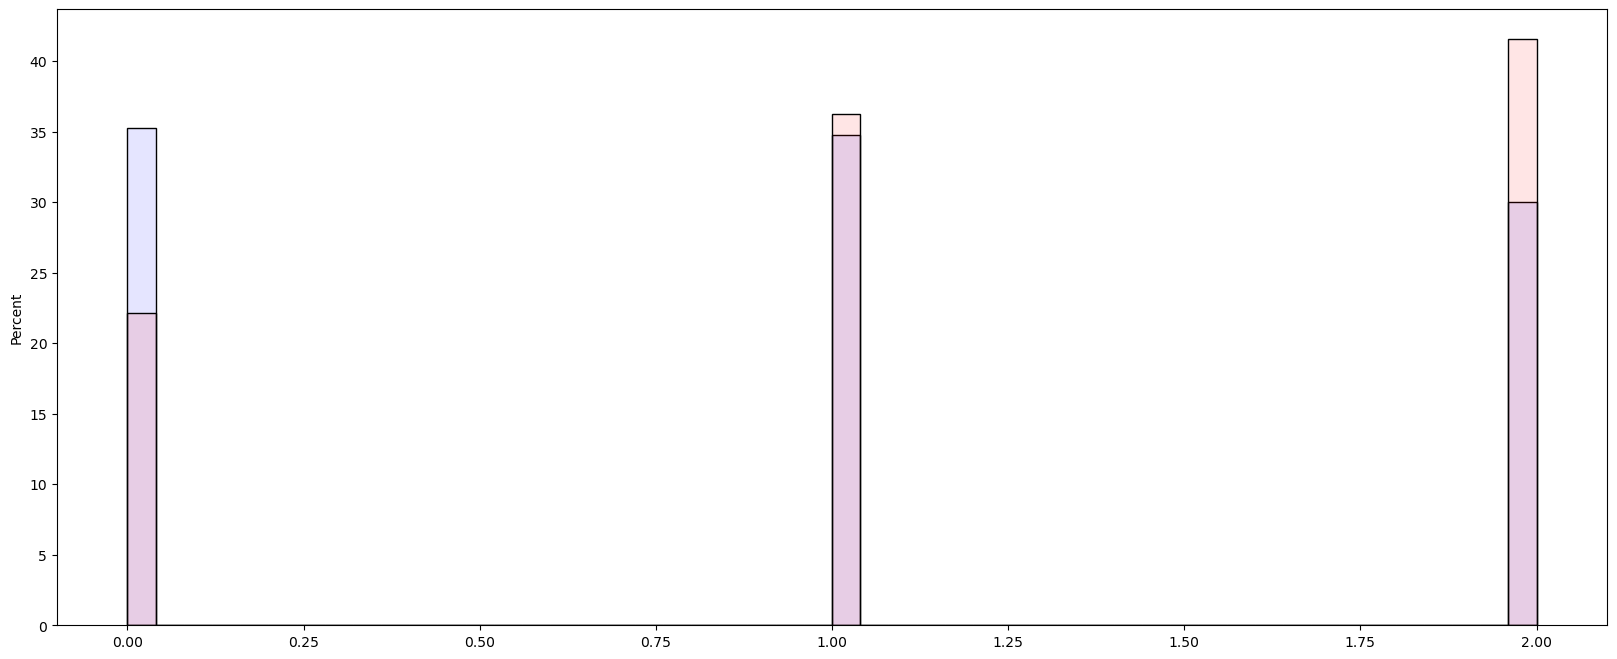

In [64]:
alpha=0.1
sns.histplot(y_pred, color='blue', bins=50, stat='percent', alpha=alpha);
sns.histplot(y_prod_pred, color='red', bins=50, stat='percent', alpha=alpha);

In [65]:
result = jensenshannon_stat_test(pd.Series(y_pred), pd.Series(y_prod_pred), 'cat', threshold=None)
result

StatTestResult(drift_score=0.11127100401533484, drifted=True, actual_threshold=0.1)

In [66]:
assert result.drifted

# Pre Processing - TODO - extend to all variables

Is the data feed into the model in the accepted range? Range is what has been covered by training data at all

In [67]:
age_range=range(10, 150)
power_range=range(50, 250)
def check_range(age, power):
    return age in age_range and power in power_range

In [68]:
assert check_range(age=30, power=150)

In [69]:
assert check_range(age=130, power=350) == False

# Post Processing

* are we certain enough, i.e. is the proba above a certain threshold? 
* if not fall back onto very simple rule system
* rule system should have high bias (underfit), but should be pretty robust to changes in input 

In [70]:
LOW_RISK = 2
MEDIUM_RISK = 1
HIGH_RISK = 0

class ClassifierBase:
    def predict(self, X):
        return np.array([ self.predict_single(x) for x in X])
    def score(self, X, y):
        n = len(y)
        correct = 0
        predictions = self.predict(X)
        for prediction, ground_truth in zip(predictions, y):
            if prediction == ground_truth:
                correct = correct + 1
        return correct / n

In [71]:
from random import randrange

class RandomClassifier(ClassifierBase):
    def predict_single(self, x):
        return randrange(3)
base_clf = RandomClassifier()    
base_clf.score(X, y)        

0.336

In [72]:
# just return most frequent value might be a baseline
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([464, 390, 346]))

In [73]:
class NaiveClassifier(ClassifierBase):
    def predict_single(self, x):
        return HIGH_RISK
base_clf = NaiveClassifier()    
base_clf.score(X, y)    

0.38666666666666666

In [74]:
df.columns

Index(['training', 'age', 'emergency_braking', 'braking_distance', 'power',
       'miles', 'risk', 'group_name', 'group'],
      dtype='object')

In [75]:
class BaseLineClassifier(ClassifierBase):
    def predict_single(self, x):
        training, age, emergency_braking, braking_distance, power, miles = x
#         print(age, power, miles)
        if training: 
            return LOW_RISK
        if age < 30:
            if power > 130:
                return HIGH_RISK
            else:
                return MEDIUM_RISK
        if age > 50:
            return HIGH_RISK
        if emergency_braking:
            return LOW_RISK
        if miles > 50:
            return HIGH_RISK
        if miles > 30:
            return MEDIUM_RISK
        # default
        return LOW_RISK
base_clf = BaseLineClassifier() 
base_clf.score(X, y)

0.5866666666666667

# Saving Model

In [76]:
# model.save?

In [77]:
model.save('classifier.h5', save_format='h5')

In [78]:
model.save('classifier', save_format='tf')

2023-04-28 15:21:15.320859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-04-28 15:21:15.344148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-04-28 15:21:15.362714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,100]
	 [[{{node inputs}}]]
2023-04-28 15:21

INFO:tensorflow:Assets written to: classifier/assets


INFO:tensorflow:Assets written to: classifier/assets


In [79]:
!ls -l

total 2036
drwxr-xr-x 4 olli olli    4096 Apr 28 15:21 classifier
-rw-r--r-- 1 olli olli  333608 Apr 28 15:21 classifier.h5
-rw-r--r-- 1 olli olli  289419 Apr 28 15:18 classifier.tgz
-rw-r--r-- 1 olli olli 1453746 Apr 28 15:20 exploration.ipynb


In [80]:
!ls -l classifier/

total 392
drwxr-xr-x 2 olli olli   4096 Apr 28 15:07 assets
-rw-r--r-- 1 olli olli     55 Apr 28 15:21 fingerprint.pb
-rw-r--r-- 1 olli olli  23997 Apr 28 15:21 keras_metadata.pb
-rw-r--r-- 1 olli olli 361007 Apr 28 15:21 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Apr 28 15:21 variables


In [81]:
!tar czvf classifier.tgz ./classifier

./classifier/
./classifier/fingerprint.pb
./classifier/keras_metadata.pb
./classifier/assets/
./classifier/variables/
./classifier/variables/variables.data-00000-of-00001
./classifier/variables/variables.index
./classifier/saved_model.pb


In [82]:
!ls -l

total 2036
drwxr-xr-x 4 olli olli    4096 Apr 28 15:21 classifier
-rw-r--r-- 1 olli olli  333608 Apr 28 15:21 classifier.h5
-rw-r--r-- 1 olli olli  289226 Apr 28 15:21 classifier.tgz
-rw-r--r-- 1 olli olli 1453746 Apr 28 15:20 exploration.ipynb
